tfds.disable_progress_bar()

# Neural Network SMS Text Classifier

## Note

The training time for this problem is painfully slow!

Here's [a good tutorial on RNN and `TextVectorization`](https://www.tensorflow.org/tutorials/text/text_classification_rnn) that you can follow to solve this problem. However, make sure to follow it closely. I waste a lot of time by skipping these 2 lines, thinking that it's just an optimization. It's not. It actually reshape the data sets. Without it, the model can't fit.

```py
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
```

Total time for this: **3.5h**

## Problem description

Copied and modified from [this Google Colab](https://colab.research.google.com/github/freeCodeCamp/boilerplate-neural-network-sms-text-classifier/blob/master/fcc_sms_text_classification.ipynb)

In this challenge, you need to create a machine learning model that will
classify SMS messages as either "ham" or "spam". A "ham" message is a normal
message sent by a friend. A "spam" message is an advertisement, or a message
sent by a company.

You should create a function called `predict_message` that takes a message
string as an argument and returns a list. The first element in the list should
be a number between zero and one that indicates the likeliness of "ham" (0) or "
spam" (1). The second element in the list should be the word "ham" or "spam",
depending on which is most likely.

For this challenge, you will use
the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/).
The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your
model and function. Add your code in between these cells.

## Solution

### Get data files

In [1]:
!wget -N https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -N https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
# !pip install tensorflow-datasets

--2021-04-01 10:05:52--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘train-data.tsv’ not modified on server. Omitting download.

--2021-04-01 10:05:52--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘valid-data.tsv’ not modified on server. Omitting download.

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### Import libraries

In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
tfds.disable_progress_bar()


### Prepare data

Train data frame

In [3]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


Test data frame

In [4]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


Prepare labels for training

In [20]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [21]:
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [29]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [30]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

This step is important. It's not only about batching the data sets, but also
**reshape** it to make it works when fitting the model. Otherwise, we will get
incompatible layers errors: `expecting ndim=3, got ndim=2`.

In [31]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Create a `TextVectorization` layer for our model

In [32]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

Let's show the vocabulary that our vectorizer has learned.

In [11]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

Create the model

In [26]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

Train the model against our data sets.

In [27]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 95s 2s/step - loss: 0.6875 - accuracy: 0.8698 - val_loss: 0.6605 - val_accuracy: 0.8604

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

In [ ]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


### Plot  the accuracy and loss metrics

Create a helper function to plot

In [14]:
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

Plot the graphs

(0.0, 0.7120187455788255)

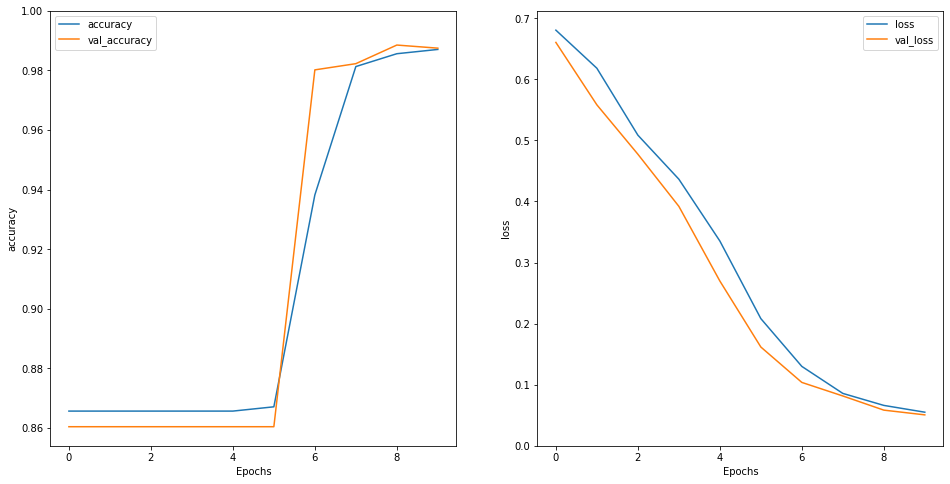

In [33]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.685122549533844, 0.6610108613967896, 0.6214703917503357, 0.5557080507278442, 0.5083892941474915, 0.46426263451576233, 0.41340407729148865, 0.36467596888542175, 0.2803434431552887, 0.20027196407318115]
[0.6743746995925903]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127]
[0.8656609058380127]


In [16]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    ps = model.predict([pred_text])
    print(ps)
    p = ps[0][0]
    return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

[[-2.2313757]]
[-2.2313757, 'ham']


## Test

In [34]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460 4",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


[[-4.9215975]]
[[0.6041299]]
[[-10.045661]]
[[1.1062595]]
[[2.3928475]]
[[-8.468976]]
[[-9.055269]]
You passed the challenge. Great job!
